AS.430.271.81: M09 - Adam Thomas

# M09 Homework - DBScan Clustering
This JupyterLab Notebook will implement the following tasks:

- Load the Utah crash site data
- Perform clustering
- Visualize clusters
- Visualize contextual clusters

In [1]:
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

# Set default map source for contextily
map_source = 'https://api.mapbox.com/styles/v1/mapbox/dark-v11/tiles/{z}/{x}/{y}?access_token=pk.eyJ1IjoiYW10aG9tYXMiLCJhIjoiY2xkcDkzbzQwMHh5bTN1a2R3MGlydnN6ZyJ9.uQjZh-jqKwgLX7alCt2foQ'

## Load the shapefile data

The method shown below is how I would like to achieve the data prep purely in Python before performing the DBScan clustering.
Unfortunately the Roads.shp file is too big to be loaded using geopandas and this step kept timing out.
I've left these steps commented so that you can see my logic.

In [2]:
# # Load the crash shapefile into a dataframe
# crash_df = gpd.read_file('Crash.shp')
# crash_df.head()

# # Load the roads shapefile into a dataframe
# roads_df = gpd.read_file('Roads.shp')
# roads_df.head()

# # convert both dataframes from WGS84 to Utah UTM zone 12 (EPSG:26912) for easier distance calculations.
# crash_df.to_crs('EPSG:26912')
# roads_df.to_crs('EPSG:26912')

# # Get all crashes within 10m of road centerlines
# # Eliminate any crash site that is not within 10m of the road centerline. This allows us to use crash sites that are not coincident with the road centerline (most points do not fall exactly on the line) without altering the original location of the crash site (e.g. snapping points to lines). This also makes the clustering more representative of the true crash site location.
# # So in this method, remove any points that are not within a 10m buffer of the road centerline.
# roads_buffer = roads_df.buffer(10)
# crash_df = crash_df.clip(roads_buffer)

So instead of the above method, I created a new Crash_Centerline.shp file using ArcGIS Pro by exporting a selection of crash sites that are within 10m of the road centerline. This would be the same result as above, but got me past the timeout issue.

Also, because the Crash Sites already contain the utm_x and utm_y coordinates, I don't explicitly need a geometry-aware version of this data, so just exporting the attribute table to .csv reduced the size tremendously.

In [3]:
# Load the roads shapefile into a dataframe
crash_df = pd.read_csv('Crash_Centerline.csv')
crash_df.head()

# Convert input to geodataframe
crash_gdf = gpd.GeoDataFrame(crash_df, geometry=gpd.points_from_xy(crash_df['utm_x'], crash_df['utm_y']), crs=f"EPSG:26912")

## Cluster road crashes

In [4]:
# Cluster the utm coordinates with a minimum of 10 points
crash_input = crash_df[['utm_x', 'utm_y']].values
crash_model = DBSCAN(eps=0.5, min_samples=10).fit(crash_input)

# Add cluster result to third column of cluster input
crash_result = np.insert(crash_input, 2, crash_model.fit_predict(crash_input), 1)

## Plot All Clusters

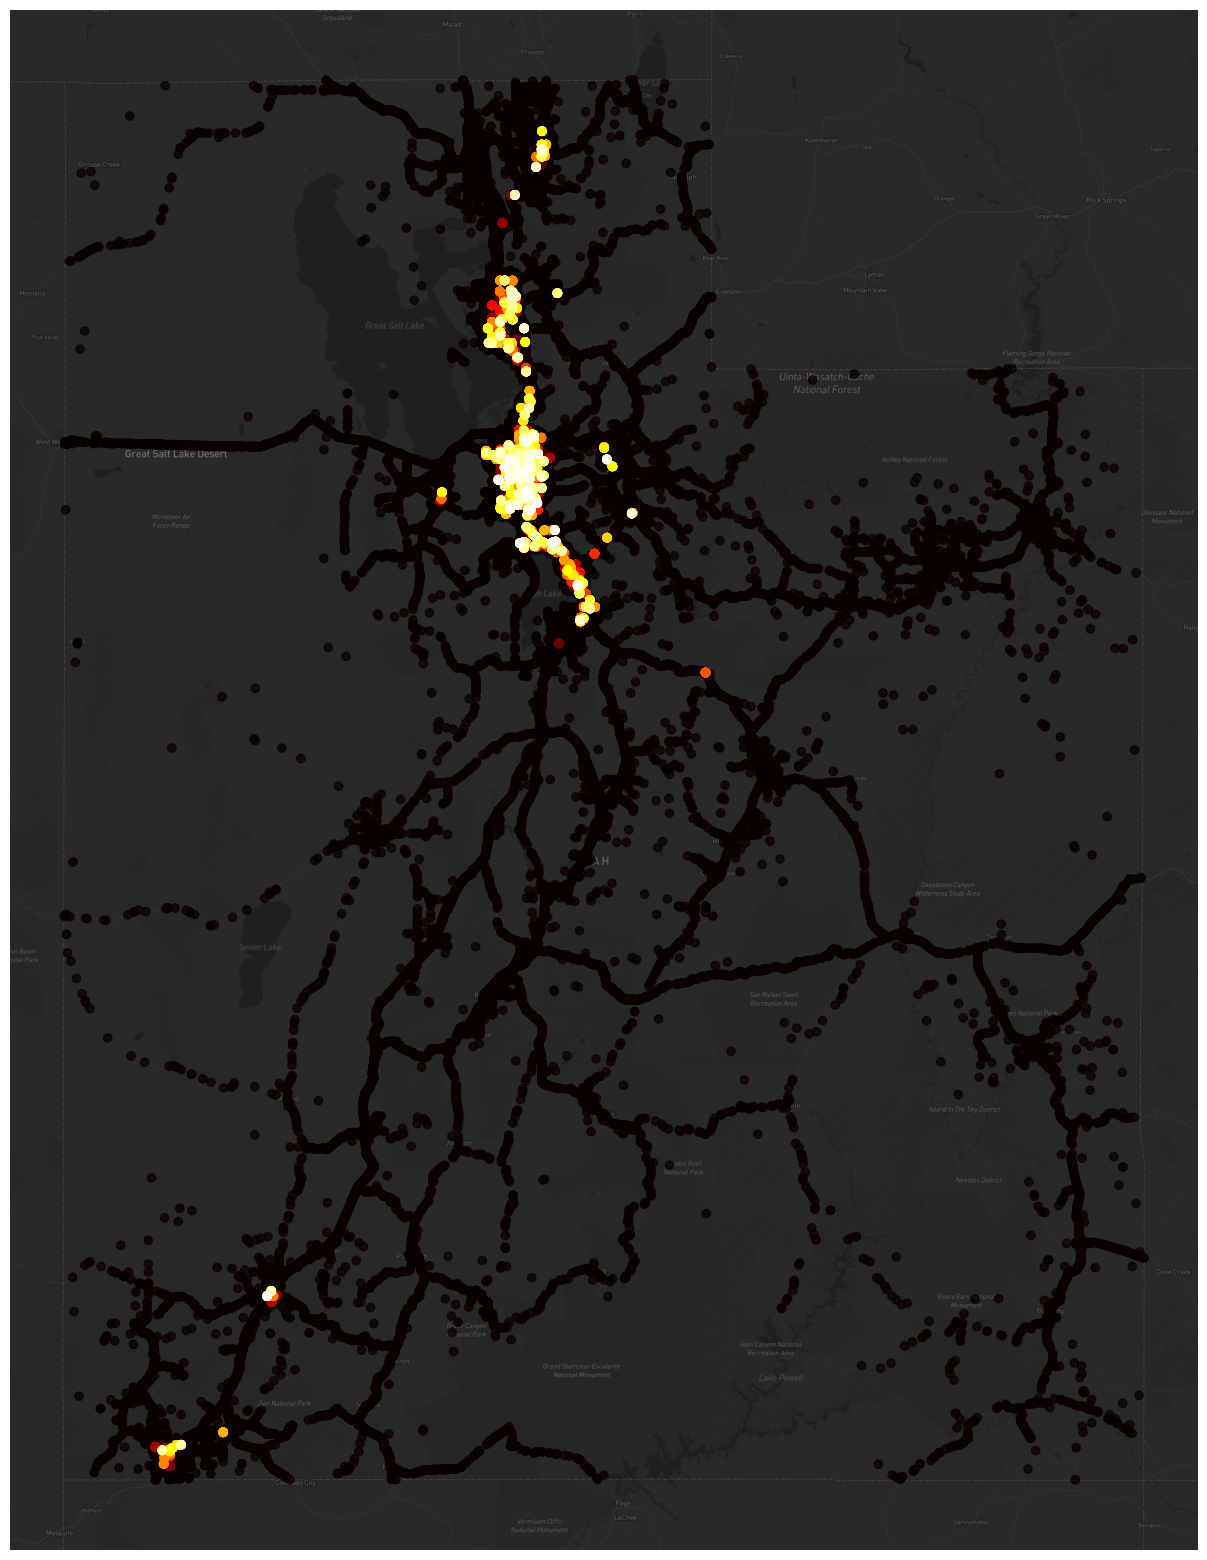

In [5]:
# Convert results to dataframe, sorted by cluster value (i.e. -1 outliers will be plotted first, and therefore underneath actual clusters)
crash_result_df = pd.DataFrame(crash_result).sort_values(by=[2])
crash_result_df.columns = ['x','y','cluster']

# Convert to geopandas dataframe for contextual plotting - symbolize the color based on the resulting cluster label
crash_result_gdf = gpd.GeoDataFrame(crash_result_df, geometry=gpd.points_from_xy(crash_result_df.x, crash_result_df.y), crs=f"EPSG:26912")
ax = crash_result_gdf.to_crs(epsg=3857).plot(figsize=(20, 20), column=crash_result_gdf['cluster'], cmap='hot', alpha=0.75, edgecolor="face", linewidth=1)
ctx.add_basemap(ax, source=map_source)
ax.set_axis_off()

Based on the image above, the majority of the dataset comprises outliers that have not been clustered. These are shown in black. The resulting clusters shown in brighter colors are focused in populated areas around larger cities like Salt Lake City and Provo, which makes sense since these are where most people are located and naturally more accidents would occur.

But let's have a closer look at the area around Salt Lake City to see the resulting data in more detail...

## Plot Salt Lake City Clusters

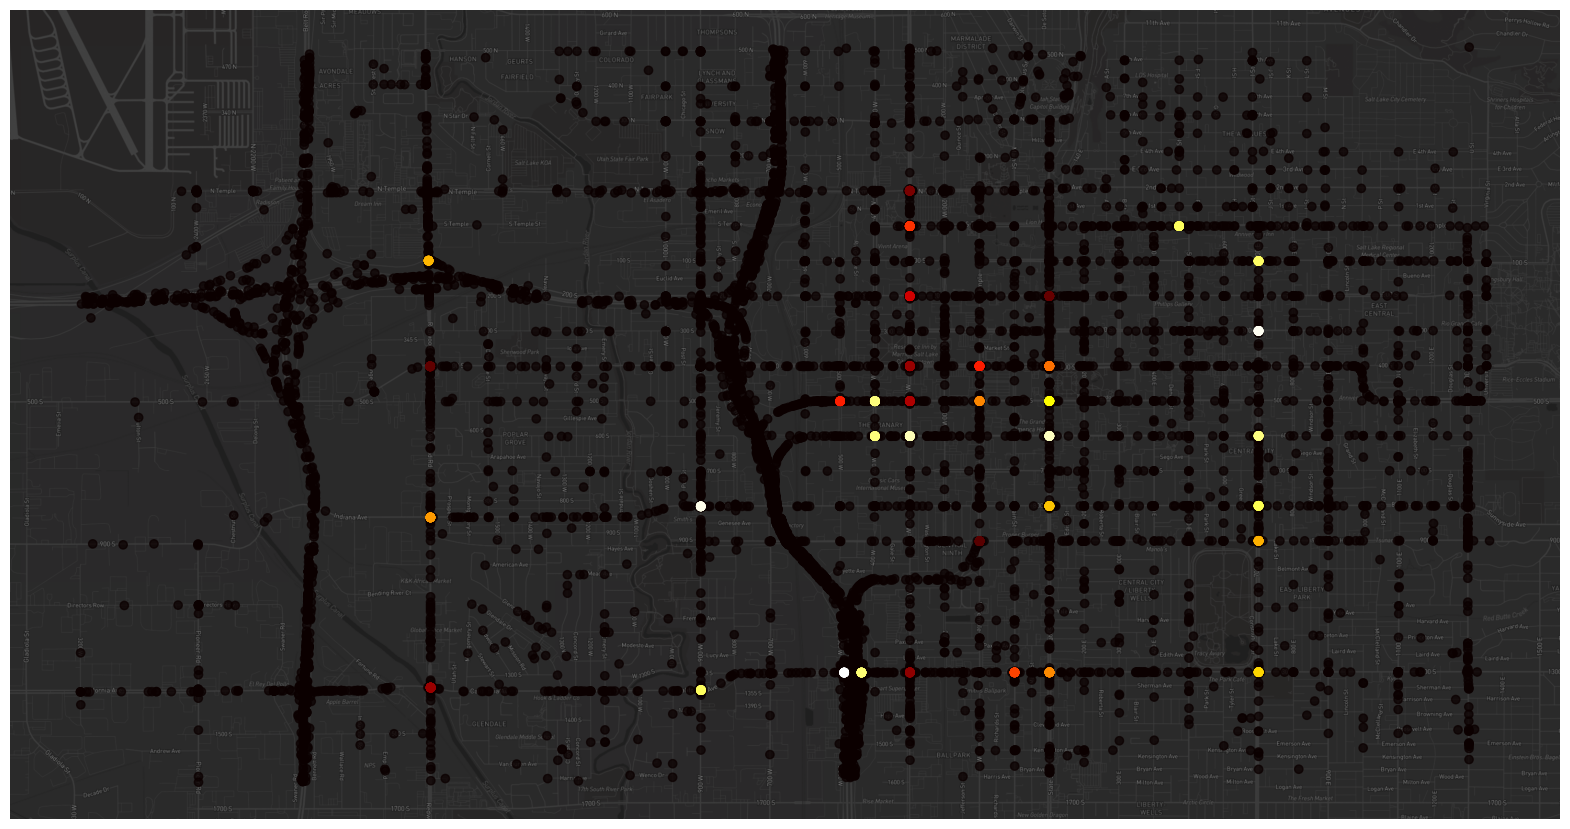

In [6]:
# Filter geodataframe to within bounding box coordinates of Salt Lake City
xmin,ymin,xmax,ymax = [418268.7881,4509736.4547,428066.6170,4514773.9529]
slc_gdf = crash_result_gdf[(crash_result_gdf['x'].between(xmin,xmax)) & 
                           (crash_result_gdf['y'].between(ymin,ymax))]

# Convert to geopandas dataframe for contextual plotting - symbolize the color based on the resulting cluster label
ax = slc_gdf.to_crs(epsg=3857).plot(figsize=(20, 20), column=slc_gdf['cluster'], cmap='hot', alpha=0.75, edgecolor="face", linewidth=1)
ctx.add_basemap(ax, source=map_source)
ax.set_axis_off()

The map above shows where crash sites have been clustered around Salt Lake City. Black points are unclustered outliers, and colored points are the locations of resulting clusters. Based on this image and basemap, it seems that all of these clustered points occured at major road intersections rather than along individual segments of roads, suggesting that intersections are responsible for more crashes.

Although this plot shows us _where_ clusters are occuring, it does not help us visualize the severity of the cluster. Let's do this next.

## Contextual Plot of Salt Lake City Clusters

In order to produce a more meaningful plot of clusters that shows us the severity of crash sites, we need to aggregate the data based on it's cluster value, and symbolize the cluster markers based on the number of clustered points.

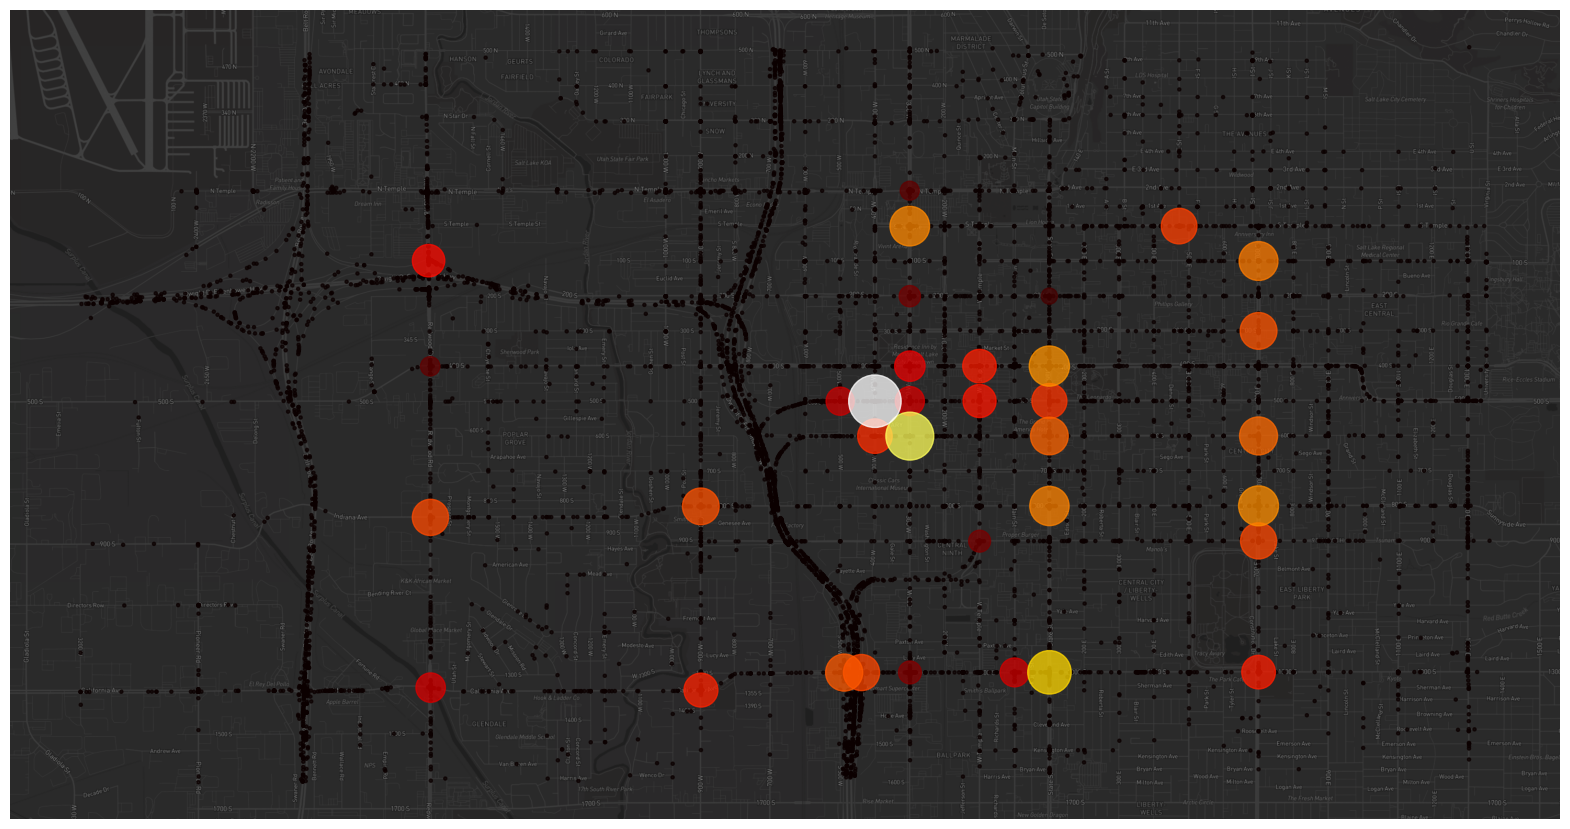

In [7]:
# Create raw_data geodataframe with cmarker size column
slc_data = slc_gdf
slc_data.insert(2,'count', 1.0)
slc_data.insert(3,'marker', 5.0)

# Create new clusters geodataframe based on aggregated clusters
# Use cluster count column as marker size (clusters should be at least 10, so will be bigger than raw_data sizes)
clusters = slc_gdf[slc_gdf['cluster'] != -1].groupby('cluster').agg({'x':'mean','y':'mean','cluster':'sum'}).rename(columns={'cluster':'count'}).reset_index()
clusters = gpd.GeoDataFrame(clusters, geometry=gpd.points_from_xy(clusters.x, clusters.y), crs=f"EPSG:26912")

# Scale the marker size appropriately
clusters['marker'] = clusters['count']/10

# Re-combine outliers and aggregated clusters
results = pd.concat([slc_data, clusters.sort_values(by=['count'])])

# Plot contextual results - symbolize the size and color based on the resulting cluster count, which was renamed to 'size'
ax = results.to_crs(epsg=3857).plot(figsize=(20, 20), label=results['marker'], column=results['marker'], cmap='hot', alpha=0.75, edgecolor="face", linewidth=1, markersize=results['marker'])
ctx.add_basemap(ax, source=map_source)
ax.set_axis_off()

The above map is a much more descriptive visualization of the intensity of clusters, with smaller and darker markers representing a lower number of clustered incidents, and the larger brighter markers representing a higher number of clustered incidents. There is one location here shown in white that represents the location of the largest number of incidents.

## Contextual Plot of all data
Let's do the same as above, but this time on the entire data set.

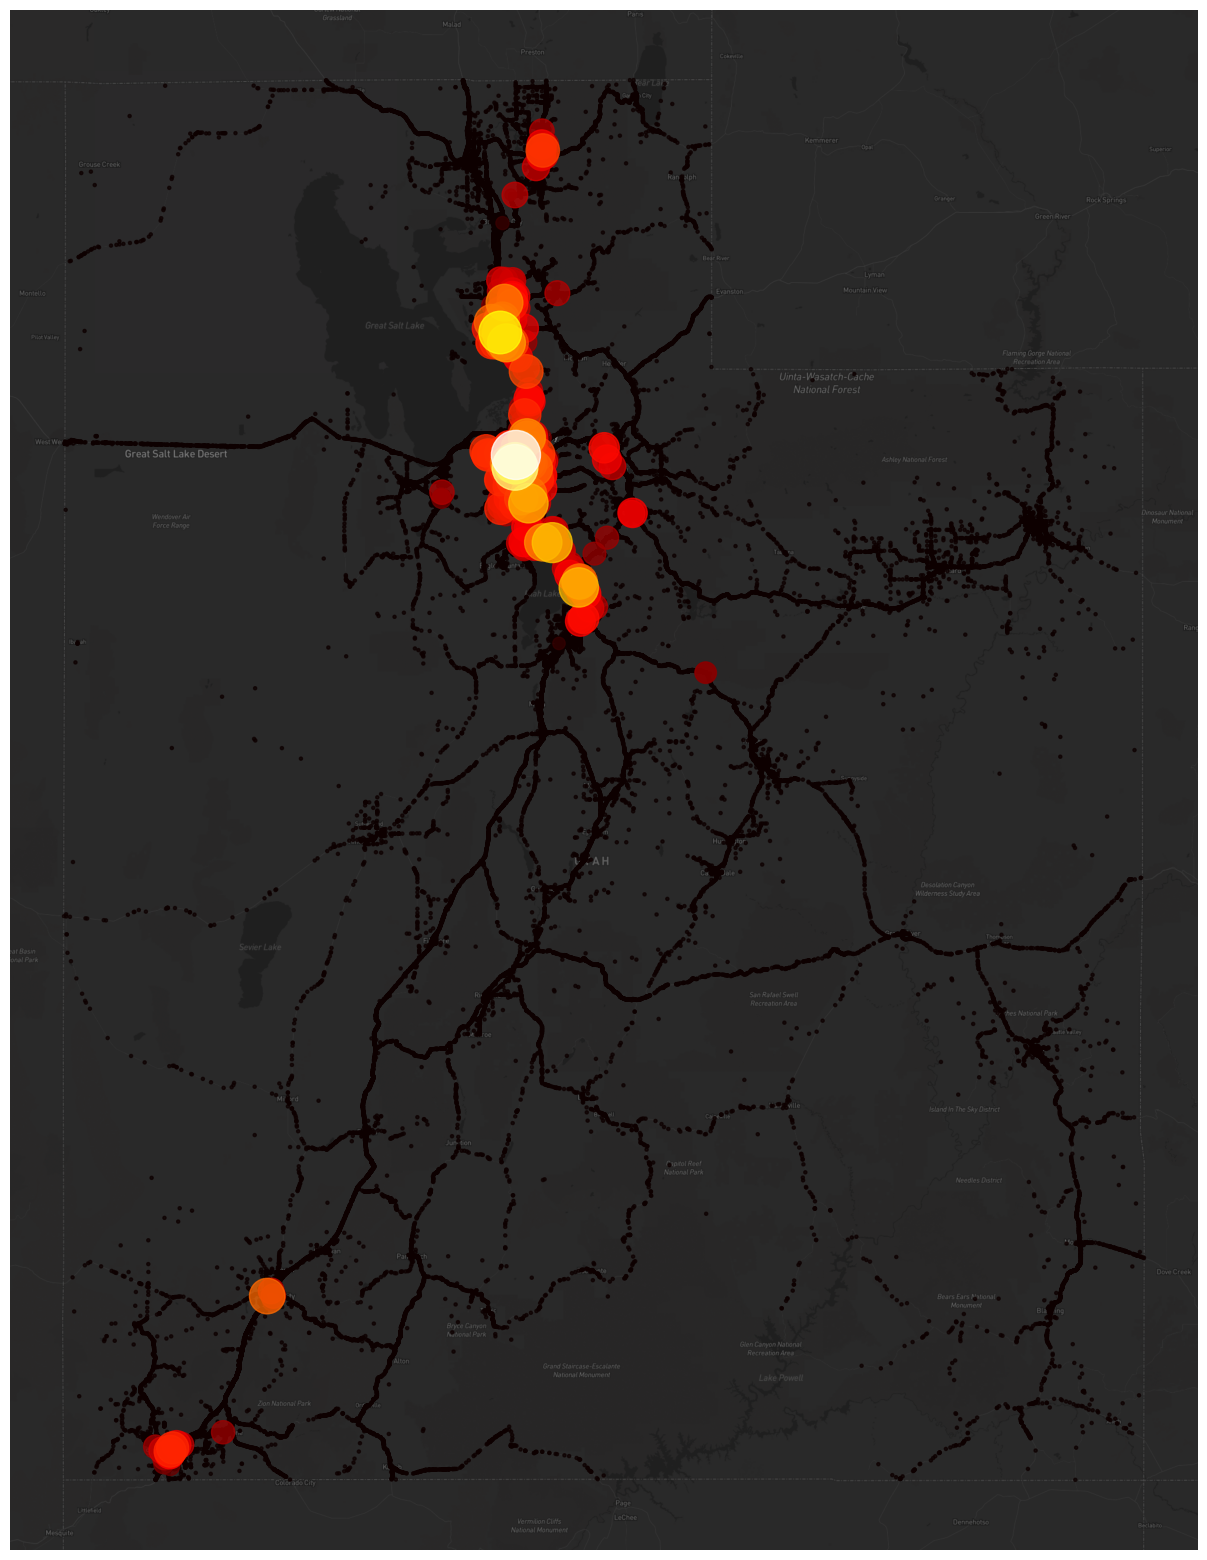

In [8]:
# Create raw_data geodataframe with cmarker size column
raw_data = crash_result_gdf
raw_data.insert(2,'count', 1.0)
raw_data.insert(3,'marker', 5.0)

# Create new clusters geodataframe based on aggregated clusters
# Use cluster count column as marker size (clusters should be at least 10, so will be bigger than raw_data sizes)
clusters = crash_result_gdf[crash_result_gdf['cluster'] != -1].groupby('cluster').agg({'x':'mean','y':'mean','cluster':'sum'}).rename(columns={'cluster':'count'}).reset_index()
clusters = gpd.GeoDataFrame(clusters, geometry=gpd.points_from_xy(clusters.x, clusters.y), crs=f"EPSG:26912")

# Scale the marker size appropriately
clusters['marker'] = clusters['count']/20

# Re-combine outliers and aggregated clusters
results = pd.concat([raw_data, clusters.sort_values(by=['count'])])

# Plot contextual results - symbolize the size and color based on the resulting cluster count, which was renamed to 'size'
ax = results.to_crs(epsg=3857).plot(figsize=(20, 20), label=results['marker'], column=results['marker'], cmap='hot', alpha=0.75, edgecolor="face", linewidth=1, markersize=results['marker'])
ctx.add_basemap(ax, source=map_source)
ax.set_axis_off()

Beautiful! Because the drawing order is based on cluster count, the most numerous clusters are drawn on top, which means that the largest cluster of incidents occurs in Salt Lake City, which is the most populous city in the data set.